Celem ćwiczenia jest prezentacja możliwości wykorzystania metod uczenia maszynowego
w rozpoznawaniu komend głosowych.

Materiałem użytym w ćwiczeniu będą próbki nagrań komend z poprzednich ćwiczeń.
Przypomnijmy, w zbiorze jest:
- 30 (+szum) komend,
- nagranych ok. 1,7-2,4 tys. razy.

Treścią zadania jest klasyfikacja komend:
- klasa (class) = komenda,
- próbka (sample) = nagranie.

Ćwiczenie podzielone jest na cztery etapy:
1. Ekstrakcja cech z próbek
2. Podział próbek na treningowe i testowe
3. Uczenie klasyfikatora
4. Klasyfikacja nieznanej próbki
5. Ocena działania klasyfikatora


In [ ]:
# import bibliotek
import os
import librosa
import pickle
import sklearn
import numpy
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# 1. Ekstrakcja cech z próbek
# Lista ekstraktorów cech: https://librosa.github.io/librosa/feature.html

# ścieżka z folderami z nagraniami - próbki:
#train_audio_path = 'C://Users/Dell/Desktop/SG/lab3/train/audio'
train_audio_path = 'D:/Guosowe/lab3/train/audio'
commands = os.listdir(train_audio_path);  

# użyjemy MFCC, tj. Mel-frequency cepstral coefficients
# jednym z parametrów jest liczba wyjściowych współczynników:
n_mfcc = 9

# wczytujemy każde nagranie, wykonujemy ekstrakcję i zapamiętujemy jej wynik
classes = []
class_size = 100 # użyjemy tylko po kilka danych
samples = []
labels = []
print("\nClass: ", end = '')
for command in commands:
    classes.append(command)
    print(command, end = ', ')
    sample_num = 0
    for file in os.listdir(train_audio_path + '/' + command + '/'):
        # print(".", end = '')
        sample_num += 1
        # przykład z MFCC:
        # y - waveform, sr - sampling rate, n_mfcc - number of MFCCs to return
        y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
        mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
        mean_mfcc_seq = []
        for feature in mfcc_seq:
            mean_mfcc_seq.append(numpy.mean(feature))
        samples.append(mean_mfcc_seq)
        labels.append(command)
        if sample_num == class_size:
            break

# warto podglądnąć, dla mniejszych n_mfcc, np. 5 co kryje mfcc_seq i mean_mfcc_seq


Class: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero, _background_noise_, 

In [ ]:
# zapiszmy bazę do późniejszej pracy
database = open('./tmp/database.pkl', 'wb')
pickle.dump([classes, samples, labels], database)
database.close()

Ocena klasyfikatora: 11.67 %


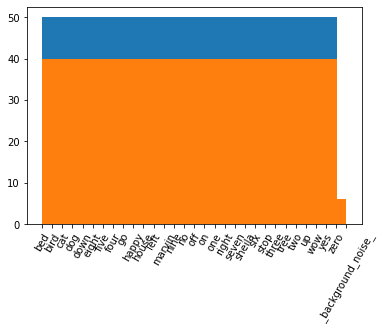

In [ ]:
# 2. Wybór danych treningowych i testowych

# Zautomatyzowany i losowy sposób to użycie:
# "from sklearn.model_selection import train_test_split" oraz funkcji "train_test_split()"

# wczytanie danych
database = open('./tmp/database.pkl', 'rb')
classes, samples, labels = pickle.load(database)
database.close()

# wybierzmy 10 pierwszych próbek z każdej klasy jako uczące
# oraz kolejne 2 z każdej klasy jako testowe
# uwaga! train_size + test_size NIE może przekroczyć class_size (poprzedni punkt)
train_size = 40
test_size = 10
train_samples = []
train_labels = []
test_samples = []
test_labels = []
for classname in classes:
    train_size_index = 0
    test_size_index = 0
    for i in range(len(labels)):
        if labels[i] == classname and train_size_index < train_size:
            train_samples.append(samples[i])
            train_labels.append(labels[i])
            train_size_index += 1
        elif labels[i] == classname and test_size_index < test_size:
            test_samples.append(samples[i])
            test_labels.append(labels[i])
            test_size_index += 1
        if train_size_index == train_size and test_size_index == test_size:
            break
            
# proszę sprawdzić, czy dane zostały wybrane prawidłowo
plt.xticks(rotation=60)
plt.hist(test_labels+train_labels,len(classes))
plt.hist(train_labels,len(classes))

# 3. Uczenie klasyfikatora danymi treningowymi

# Lista klasyfikatorów: https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
# Prosty tutorial: https://www.digitalocean.com/community/tutorials/how-to-build-a-machine-learning-classifier-in-python-with-scikit-learn

# skalowanie/normalizacja danych
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_samples)
train_samples = scaler.transform(train_samples)
test_samples = scaler.transform(test_samples)

# uczenie
from sklearn.neighbors import KNeighborsClassifier
k = 5
classifier = KNeighborsClassifier(n_neighbors = k)
classifier.fit(train_samples, train_labels)


# 4. Klasyfikacja nieznanych próbek
predicted_labels = classifier.predict(test_samples)
    
# zobaczmy wynik - zakomentować dla dużych zbiorów
#print(test_labels)
#print(predicted_labels)


# 5. Ocena klasyfikatora
# print(test_labels == predicted_labels)
quality = numpy.sum(test_labels == predicted_labels) / len(test_labels) * 100;
print('Ocena klasyfikatora: %.2f %%' % quality)

## Badanie optymalnego n_mfcc

In [ ]:
def QualityForNMfcc(n_mfcc,class_size):
    # ścieżka z folderami z nagraniami - próbki:
    train_audio_path = 'C://Users/Dell/Desktop/SG/lab3/train/audio'
    commands = os.listdir(train_audio_path);  

    # wczytujemy każde nagranie, wykonujemy ekstrakcję i zapamiętujemy jej wynik
    classes = []
    samples = []
    labels = []
    for command in commands:
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            # przykład z MFCC:
            # y - waveform, sr - sampling rate, n_mfcc - number of MFCCs to return
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            mean_mfcc_seq = []
            for feature in mfcc_seq:
                mean_mfcc_seq.append(numpy.mean(feature))
            samples.append(mean_mfcc_seq)
            labels.append(command)
            if sample_num == class_size:
                break
    
    # wczytujemy każde nagranie, wykonujemy ekstrakcję i zapamiętujemy jej wynik
    train_size = 40
    test_size = 10
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for classname in classes:
        train_size_index = 0
        test_size_index = 0
        for i in range(len(labels)):
            if labels[i] == classname and train_size_index < train_size:
                train_samples.append(samples[i])
                train_labels.append(labels[i])
                train_size_index += 1
            elif labels[i] == classname and test_size_index < test_size:
                test_samples.append(samples[i])
                test_labels.append(labels[i])
                test_size_index += 1
            if train_size_index == train_size and test_size_index == test_size:
                break
            
    # skalowanie/normalizacja danych
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    # uczenie
    from sklearn.neighbors import KNeighborsClassifier
    k = 5
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_samples, train_labels)

    predicted_labels = classifier.predict(test_samples)

    quality = numpy.sum(test_labels == predicted_labels) / len(test_labels) * 100;
    return quality

In [ ]:
QualityForNMfcc(20,50)

10.333333333333334


NMfcc: 10->20->30->40->50->60->70->80->90->100->

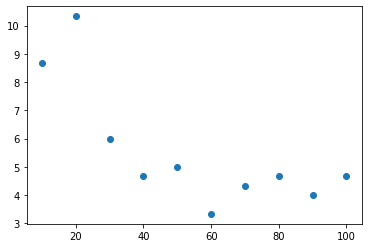

In [ ]:
n_mfcc_tab=[i*10 for i in range(1,11)]
quality=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality.append(QualityForNMfcc(n_mfcc_tmp,50))

plt.scatter(n_mfcc_tab,quality)


NMfcc: 1->2->3->4->5->6->7->8->9->

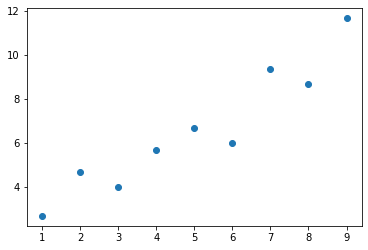

In [ ]:
n_mfcc_tab=[i for i in range(1,10)]
quality=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality.append(QualityForNMfcc(n_mfcc_tmp,50))

plt.scatter(n_mfcc_tab,quality)


NMfcc: 11->12->13->14->15->16->17->18->19->

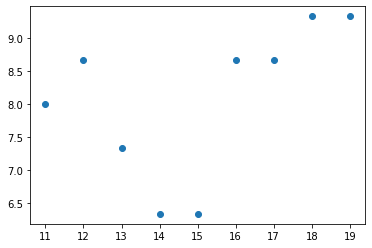

In [ ]:
n_mfcc_tab=[i+10 for i in range(1,10)]
quality=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality.append(QualityForNMfcc(n_mfcc_tmp,50))

plt.scatter(n_mfcc_tab,quality)

### Optymalne n_mfcc=9
## Szukanie optymalnego train_size

In [ ]:
def trainKNN(train_size,k):
    database = open('./tmp/database.pkl', 'rb')
    classes, samples, labels = pickle.load(database)
    database.close()

    # wybierzmy 10 pierwszych próbek z każdej klasy jako uczące
    # oraz kolejne 2 z każdej klasy jako testowe
    # uwaga! train_size + test_size NIE może przekroczyć class_size (poprzedni punkt)
    test_size = 10
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for classname in classes:
        train_size_index = 0
        test_size_index = 0
        for i in range(len(labels)):
            if labels[i] == classname and train_size_index < train_size:
                train_samples.append(samples[i])
                train_labels.append(labels[i])
                train_size_index += 1
            elif labels[i] == classname and test_size_index < test_size:
                test_samples.append(samples[i])
                test_labels.append(labels[i])
                test_size_index += 1
            if train_size_index == train_size and test_size_index == test_size:
                break

    # skalowanie/normalizacja danych
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    # uczenie
    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_samples, train_labels)


    predicted_labels = classifier.predict(test_samples)

    quality = numpy.sum(test_labels == predicted_labels) / len(test_labels) * 100;
    return quality

In [ ]:
trainKNN(40,5)

11.666666666666666

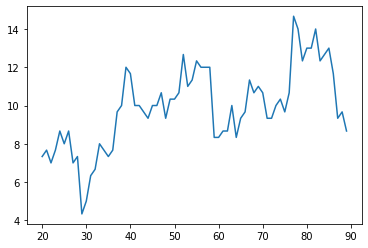

In [ ]:
test_size_tab=range(20,90)
quality_tab=[]
for test_size_tmp in test_size_tab:
    quality_tab.append(trainKNN(test_size_tmp,5))

plt.plot(test_size_tab,quality_tab)

In [ ]:
quality_tab[57]

14.666666666666666

### Optymalne train_size=57+20=77
## Szukanie optymalnego k

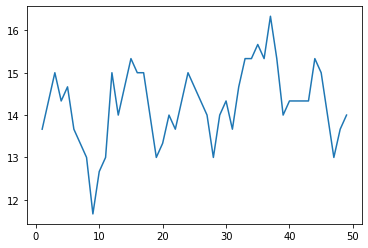

In [ ]:
train_size_optimal=77
k_tab=range(1,50)
quality_tab=[]
for k_tmp in k_tab:
    quality_tab.append(trainKNN(train_size_optimal,k_tmp))

plt.plot(k_tab,quality_tab)

In [ ]:
print(quality_tab[36])
k_optimal=37

16.333333333333332


### Optymalne k=37

Ocena klasyfikatora: 17.46 %


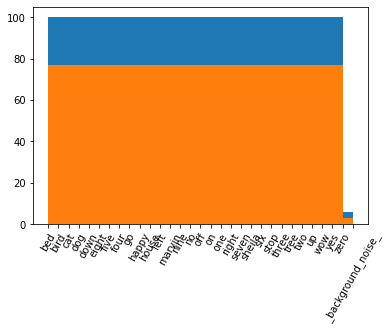

In [ ]:
# 2. Wybór danych treningowych i testowych

# Zautomatyzowany i losowy sposób to użycie:
# "from sklearn.model_selection import train_test_split" oraz funkcji "train_test_split()"

# wczytanie danych
database = open('./tmp/database.pkl', 'rb')
classes, samples, labels = pickle.load(database)
database.close()

# wybierzmy 10 pierwszych próbek z każdej klasy jako uczące
# oraz kolejne 2 z każdej klasy jako testowe
# uwaga! train_size + test_size NIE może przekroczyć class_size (poprzedni punkt)
train_size = train_size_optimal
test_size = class_size-train_size_optimal
train_samples = []
train_labels = []
test_samples = []
test_labels = []
for classname in classes:
    #losowy podział na zbiór treningowy i walidacyjny
    labels_num=0
    samples_class=[]
    for i in range(len(labels)):
        if labels[i] == classname:
            samples_class.append(samples[i])
            labels_num+=1
    labels_class=labels_num*[classname]
    if labels_num>(train_size+test_size):
        our_data_X,unused_data_X,our_data_y,unused_data_y=train_test_split(samples_class, labels_class, train_size=(train_size+test_size)/labels_num)
        train_samples_add,test_samples_add,train_labels_add,test_labels_add=train_test_split(our_data_X, our_data_y, train_size=train_size/(train_size+test_size))
    elif labels_num==(train_size+test_size):
        train_samples_add,test_samples_add,train_labels_add,test_labels_add=train_test_split(samples_class, labels_class, train_size=train_size/(train_size+test_size))
    else:
        train_samples_add,test_samples_add,train_labels_add,test_labels_add=train_test_split(samples_class, labels_class, train_size=0.5)    
    train_samples+=train_samples_add
    test_samples+=test_samples_add
    train_labels+=train_labels_add
    test_labels+=test_labels_add
            
# proszę sprawdzić, czy dane zostały wybrane prawidłowo
plt.xticks(rotation=60)
plt.hist(test_labels+train_labels,len(classes))
plt.hist(train_labels,len(classes))


# 3. Uczenie klasyfikatora danymi treningowymi

# Lista klasyfikatorów: https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
# Prosty tutorial: https://www.digitalocean.com/community/tutorials/how-to-build-a-machine-learning-classifier-in-python-with-scikit-learn

# skalowanie/normalizacja danych
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_samples)
train_samples = scaler.transform(train_samples)
test_samples = scaler.transform(test_samples)

# uczenie
from sklearn.neighbors import KNeighborsClassifier
k = k_optimal
classifier = KNeighborsClassifier(n_neighbors = k)
classifier.fit(train_samples, train_labels)


# 4. Klasyfikacja nieznanych próbek
predicted_labels = classifier.predict(test_samples)
    
# zobaczmy wynik - zakomentować dla dużych zbiorów
#print(test_labels)
#print(predicted_labels)


# 5. Ocena klasyfikatora
# print(test_labels == predicted_labels)
quality = numpy.sum(test_labels == predicted_labels) / len(test_labels) * 100;
print('Ocena klasyfikatora: %.2f %%' % quality)

# SVM

In [ ]:
def splitSamples(train_size,test_size):
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for classname in classes:
        #losowy podział na zbiór treningowy i walidacyjny
        labels_num=0
        samples_class=[]
        for i in range(len(labels)):
            if labels[i] == classname:
                samples_class.append(samples[i])
                labels_num+=1
        labels_class=labels_num*[classname]
        if labels_num>(train_size+test_size):
            our_data_X,unused_data_X,our_data_y,unused_data_y=train_test_split(samples_class, labels_class, train_size=(train_size+test_size)/labels_num)
            train_samples_add,test_samples_add,train_labels_add,test_labels_add=train_test_split(our_data_X, our_data_y, train_size=train_size/(train_size+test_size))
        elif labels_num==(train_size+test_size):
            train_samples_add,test_samples_add,train_labels_add,test_labels_add=train_test_split(samples_class, labels_class, train_size=train_size/(train_size+test_size))
        else:
            train_samples_add,test_samples_add,train_labels_add,test_labels_add=train_test_split(samples_class, labels_class, train_size=0.5)    
        train_samples+=train_samples_add
        test_samples+=test_samples_add
        train_labels+=train_labels_add
        test_labels+=test_labels_add
    
    # skalowanie/normalizacja danych
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)
    
    return train_samples,test_samples,train_labels,test_labels


### Test dla 9 cech n_mfcc

In [ ]:
from sklearn.svm import SVC

classifier=SVC(gamma=1.5,C=100)
train_samples,test_samples,train_labels,test_labels=splitSamples(80,20)
classifier.fit(train_samples, train_labels)
score = classifier.score(train_samples, train_labels)
print(score)
score = classifier.score(test_samples, test_labels)
print(score)

1.0
0.38474295190713104


### Optymalzacja parametrów

In [ ]:
from scipy import optimize as opt
train_samples,test_samples,train_labels,test_labels=splitSamples(80,20)
def score(gammaC):
    classifier=SVC(gamma=np.abs(gammaC[0]),C=np.abs(gammaC[1]))
    classifier.fit(train_samples, train_labels)
    score = classifier.score(test_samples, test_labels)
    return -score
print(opt.minimize(score,np.array([1.5,100]),method='powell'))

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-7.31047568e-12,  2.87753313e-11]])
     fun: -0.39800995024875624
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 2
  status: 0
 success: True
       x: array([  0.84252741, 105.17585792])


In [ ]:
classifier=SVC(gamma=0.72752185,C=105.17585792)
classifier.fit(train_samples, train_labels)
score = classifier.score(test_samples, test_labels)
print(score)

0.3963515754560531


### Optymalne n_mfcc oraz parametry gamma i C

In [ ]:
from scipy import optimize as opt
from sklearn.svm import SVC
def QualityForNMfccSVM(n_mfcc,train_size,test_size):
    # ścieżka z folderami z nagraniami - próbki:
    commands = os.listdir(train_audio_path);  

    # wczytujemy każde nagranie, wykonujemy ekstrakcję i zapamiętujemy jej wynik
    classes = []
    samples = []
    labels = []
    class_size=train_size+test_size
    for command in commands:
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            # przykład z MFCC:
            # y - waveform, sr - sampling rate, n_mfcc - number of MFCCs to return
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            mean_mfcc_seq = []
            for feature in mfcc_seq:
                mean_mfcc_seq.append(numpy.mean(feature))
            samples.append(mean_mfcc_seq)
            labels.append(command)
            if sample_num == class_size:
                break
    
    train_samples,test_samples,train_labels,test_labels=splitSamples(train_size,test_size)
    def score(gammaC):
        classifier=SVC(gamma=numpy.abs(gammaC[0]),C=numpy.abs(gammaC[1]))
        classifier.fit(train_samples, train_labels)
        score = classifier.score(test_samples, test_labels)
        return -score
    result=opt.minimize(score,numpy.array([1.5,100]),method='powell')
    return -result.fun,result.x

In [ ]:
QualityForNMfccSVM(9,40,10)

(0.3069306930693069, array([8.84726533e-02, 1.02624452e+02]))


NMfcc: 10->20->30->40->50->60->70->80->90->100->

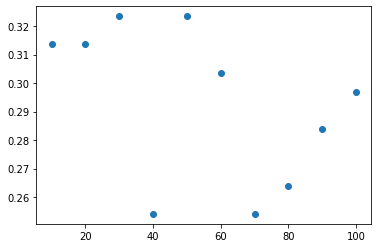

In [ ]:
n_mfcc_tab=[i*10 for i in range(1,11)]
quality_tab=[]
params_tab=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality,params=QualityForNMfccSVM(n_mfcc_tmp,40,10)
    quality_tab.append(quality)
    params_tab.append(params)

plt.scatter(n_mfcc_tab,quality_tab)


NMfcc: 1->2->3->4->5->6->7->8->9->

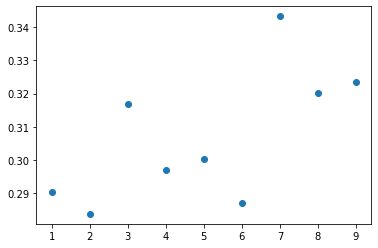

In [ ]:
n_mfcc_tab=[i for i in range(1,10)]
quality_tab=[]
params_tab=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality,params=QualityForNMfccSVM(n_mfcc_tmp,40,10)
    quality_tab.append(quality)
    params_tab.append(params)

plt.scatter(n_mfcc_tab,quality_tab)


NMfcc: 51->52->53->54->55->56->57->58->59->

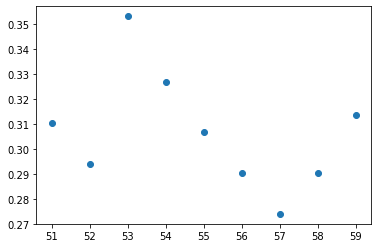

In [ ]:
n_mfcc_tab=[i+50 for i in range(1,10)]
quality_tab=[]
params_tab=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality,params=QualityForNMfccSVM(n_mfcc_tmp,40,10)
    quality_tab.append(quality)
    params_tab.append(params)

plt.scatter(n_mfcc_tab,quality_tab)

In [ ]:
quality_tab[2]

0.35313531353135313

In [ ]:
params_tab[2]

array([  0.64589804, 105.17585792])

### Optymalne n_mfcc=53
### Optymalne gamma=0.65
### Optymalne C=105.2

# Gaussian Process

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
def QualityForNMfccGaussian(n_mfcc,train_size,test_size):
    # ścieżka z folderami z nagraniami - próbki:
    commands = os.listdir(train_audio_path);  

    # wczytujemy każde nagranie, wykonujemy ekstrakcję i zapamiętujemy jej wynik
    classes = []
    samples = []
    labels = []
    class_size=train_size+test_size
    for command in commands:
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            # przykład z MFCC:
            # y - waveform, sr - sampling rate, n_mfcc - number of MFCCs to return
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            mean_mfcc_seq = []
            for feature in mfcc_seq:
                mean_mfcc_seq.append(numpy.mean(feature))
            samples.append(mean_mfcc_seq)
            labels.append(command)
            if sample_num == class_size:
                break
    
    train_samples,test_samples,train_labels,test_labels=splitSamples(train_size,test_size)
    classifier=GaussianProcessClassifier();
    classifier.fit(train_samples, train_labels)
    return classifier.score(test_samples, test_labels)

In [ ]:
QualityForNMfccGaussian(9,40,10)

0.24752475247524752


NMfcc: 10->20->30->40->50->60->70->80->90->

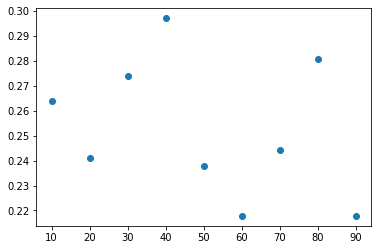

In [ ]:
n_mfcc_tab=[i*10 for i in range(1,10)]
quality_tab=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality_tab.append(QualityForNMfccGaussian(n_mfcc_tmp,40,10))

plt.scatter(n_mfcc_tab,quality_tab)


NMfcc: 1->2->3->4->5->6->7->8->9->

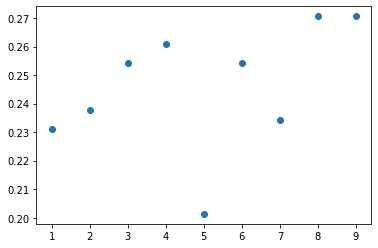

In [ ]:
n_mfcc_tab=[i for i in range(1,10)]
quality_tab=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality_tab.append(QualityForNMfccGaussian(n_mfcc_tmp,40,10))

plt.scatter(n_mfcc_tab,quality_tab)


NMfcc: 31->32->33->34->35->36->37->38->39->

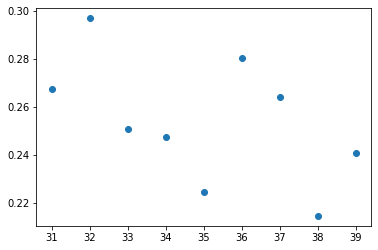

In [ ]:
n_mfcc_tab=[i+30 for i in range(1,10)]
quality_tab=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality_tab.append(QualityForNMfccGaussian(n_mfcc_tmp,40,10))

plt.scatter(n_mfcc_tab,quality_tab)

### Optymalne n_mfcc=32

# Neural Net

In [ ]:
from sklearn.neural_network import MLPClassifier
layers_num_tab=[i for i in range(5,10)]
neuron_per_layer_tab=[i for i in range(5,10)]
def QualityForNMfccNN(n_mfcc,train_size,test_size):
    # ścieżka z folderami z nagraniami - próbki:
    commands = os.listdir(train_audio_path);  

    # wczytujemy każde nagranie, wykonujemy ekstrakcję i zapamiętujemy jej wynik
    classes = []
    samples = []
    labels = []
    class_size=train_size+test_size
    for command in commands:
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            # przykład z MFCC:
            # y - waveform, sr - sampling rate, n_mfcc - number of MFCCs to return
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            mean_mfcc_seq = []
            for feature in mfcc_seq:
                mean_mfcc_seq.append(numpy.mean(feature))
            samples.append(mean_mfcc_seq)
            labels.append(command)
            if sample_num == class_size:
                break
    
    train_samples,test_samples,train_labels,test_labels=splitSamples(train_size,test_size)
    best_score=0
    for layers in layers_num_tab:
        for neurons in neuron_per_layer_tab:
            clf=MLPClassifier(hidden_layer_sizes=tuple(neurons for i in range(layers)),alpha=10, max_iter=100000,activation='logistic')
            clf.fit(train_samples,train_labels)
            if clf.score(test_samples,test_labels)>best_score:
                best_score=clf.score(test_samples,test_labels)
                best_layers=layers
                best_neurons=neurons
    return best_score,best_layers,best_neurons

In [ ]:
QualityForNMfccNN(60,40,10)

(0.033003300330033, 5, 5)


NMfcc: 10->20->30->40->50->60->70->80->90->100->

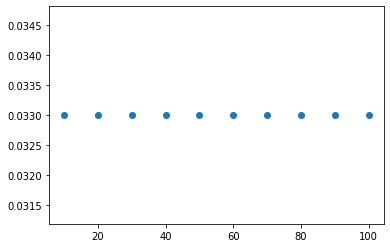

In [ ]:
n_mfcc_tab=[i*10 for i in range(1,11)]
quality_tab=[]
layers_tab=[]
neurons_tab=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality,layers,neurons=QualityForNMfccNN(n_mfcc_tmp,40,10)
    quality_tab.append(quality)
    layers_tab.append(layers)
    neurons_tab.append(neurons)

plt.scatter(n_mfcc_tab,quality_tab)


NMfcc: 1->2->3->4->5->6->7->8->9->

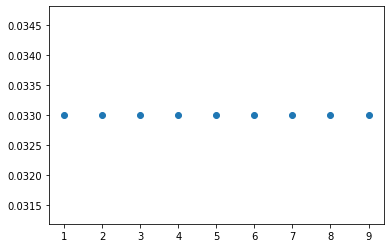

In [ ]:
n_mfcc_tab=[i for i in range(1,10)]
quality_tab=[]
layers_tab=[]
neurons_tab=[]
print("\nNMfcc: ", end = '')
for n_mfcc_tmp in n_mfcc_tab:
    print(n_mfcc_tmp,end='->')
    quality,layers,neurons=QualityForNMfccNN(n_mfcc_tmp,40,10)
    quality_tab.append(quality)
    layers_tab.append(layers)
    neurons_tab.append(neurons)

plt.scatter(n_mfcc_tab,quality_tab)

## Najlepszy model: SVM z optymlnymi n_mfcc i parametramie gamma oraz C dający wynik 35% na zbiorze walidacyjnym